# Importing libraries

In [4]:
# Install the ultralytics package for YOLOv8
!pip install ultralytics

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os
import glob
import cv2
from ultralytics import YOLO  # Import YOLO from ultralytics for object detection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 19.8 MB/s eta 0:00:0000:01


# dataset


In [2]:
# Copy dataset from the input directory to the working directory (Kaggle-specific)
# This is necessary because the input directory is read-only

# Define source and destination paths
source_dir = '/kaggle/input/my-data-n3'
destination_dir = '/kaggle/working/'


# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the dataset to the working directory
for item in os.listdir(source_dir):
    s = os.path.join(source_dir, item)
    d = os.path.join(destination_dir, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, False, None)
    else:
        shutil.copy2(s, d)


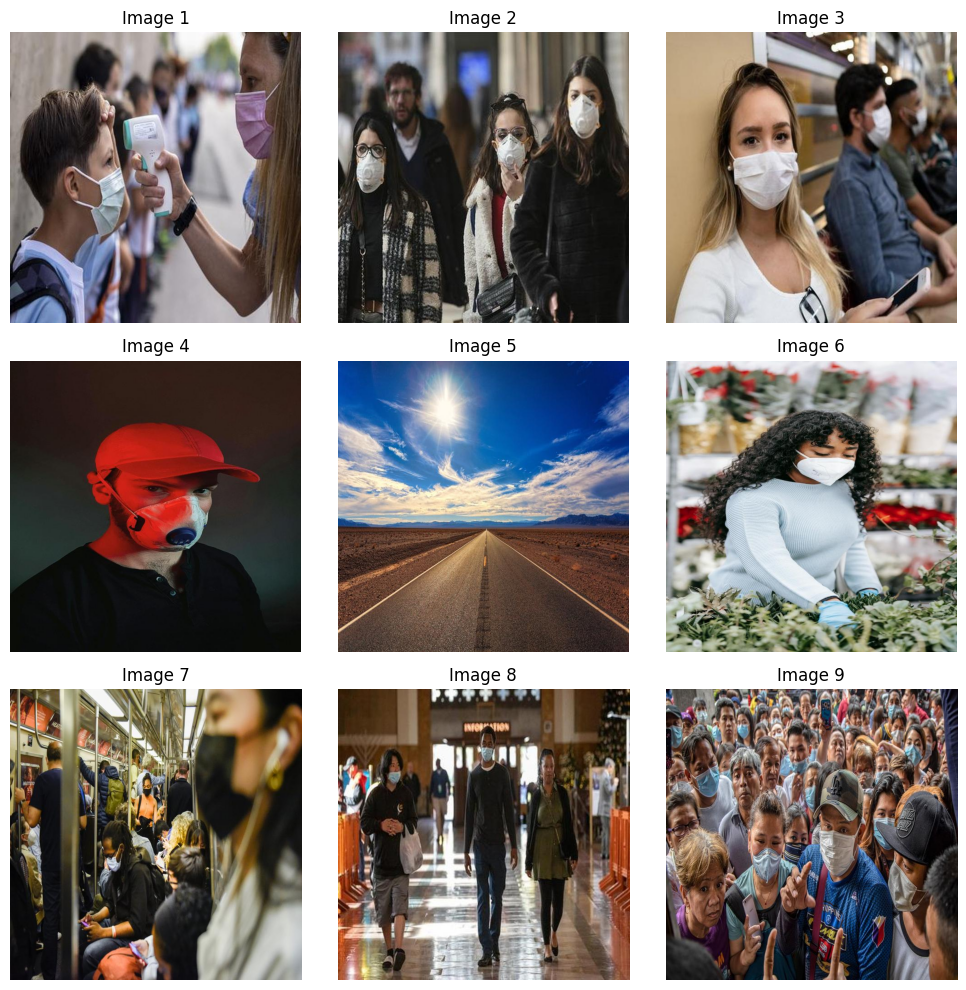

In [4]:
# Function to load and display 9 images from the training dataset
def plot_train_images(dataset_dir, num_images=9):
    # Get a list of image file names in the train directory
    image_files = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]
    
    # Sort and select the first `num_images` images
    selected_images = image_files[:num_images]

    # Create a 3x3 grid for displaying the images
    plt.figure(figsize=(10, 10))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(dataset_dir, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(3, 3, i+1)
        plt.imshow(image_rgb)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

train_dataset_dir ='/kaggle/input/my-data-n3/dataset/images/train'  
plot_train_images(train_dataset_dir)

# model Training and validation

In [ ]:
# Initialize a YOLOv8 model with a pre-trained YOLOv8 large model
model = YOLO('yolov8l.pt')  
# Train the model on my dataset
model.train(
    data='/kaggle/working/dataset/dataset.yaml',  # Path to the dataset configuration
    epochs=250,  # Number of training epochs
    optimizer='AdamW',  # Optimizer to use
    freeze=5,  # Number of layers to freeze in the backbone
    imgsz=640,  # Image size for training
    lr0=0.0001,  # Initial learning rate
    batch=32,  # Batch size
    auto_augment='none',  # Disable auto augmentation
    cls=0.2,  # Classification loss gain
    weight_decay=0.005,  # Weight decay to prevent overfitting
    label_smoothing=0.1,  # Smoothing factor for labels
    mixup=0.1,  # Probability of applying mixup augmentation
    patience=50,  # Early stopping patience
    close_mosaic=20  # Disable mosaic augmentation in the last 20 epochs
)

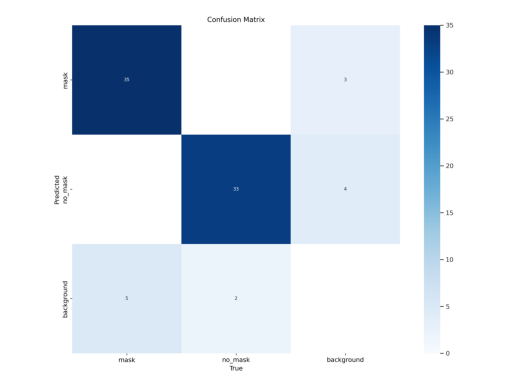

In [14]:
# Load and display the confusion_matrix
confusion_matrix_path = '/kaggle/working/runs/detect/train/confusion_matrix.png'
confusion_matrix = cv2.imread(confusion_matrix_path)
# Convert the image from BGR to RGB format (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(confusion_matrix, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

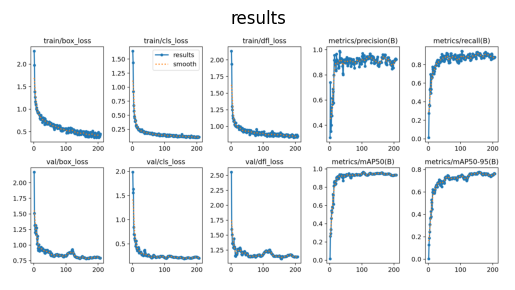

In [6]:
# Load and display the results
results_path = '/kaggle/working/runs/detect/train/results.png'
results = cv2.imread(results_path)
# Convert the image from BGR to RGB format (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(results, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title("results")
plt.axis('off')
plt.show()

In [15]:
# Load the training results from the CSV file generated by YOLOv8
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')

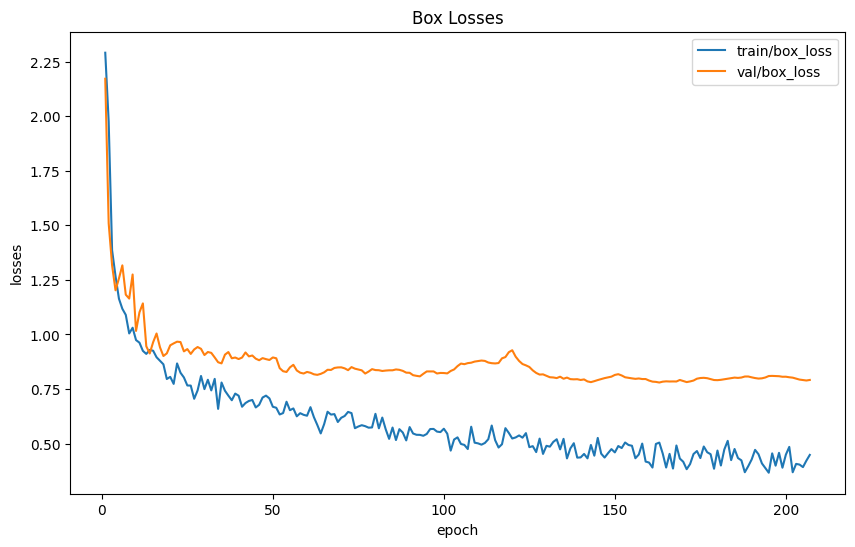

In [12]:
# Plot training and validation box loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label = 'train/box_loss')
plt.plot(df['epoch'], df['val/box_loss'], label = 'val/box_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Box Losses')
plt.show()

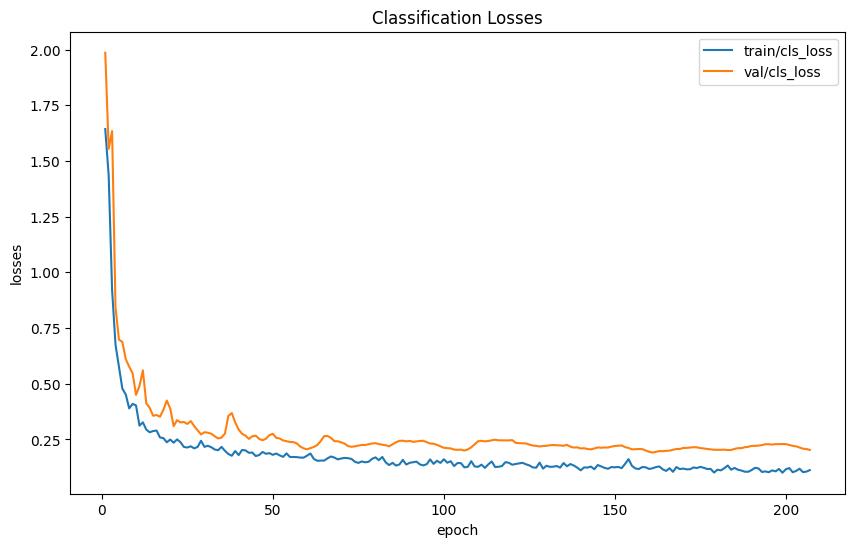

In [13]:
# Plot training and validation classification loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/cls_loss'], label = 'train/cls_loss')
plt.plot(df['epoch'], df['val/cls_loss'], label = 'val/cls_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Classification Losses')
plt.show()

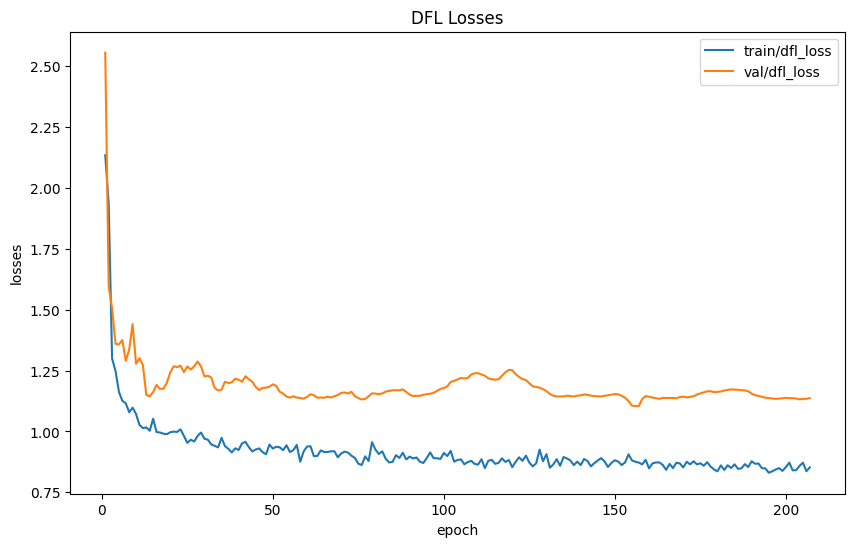

In [14]:
# Plot training and validation DFL (Distribution Focal Loss) over epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/dfl_loss'], label = 'train/dfl_loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label = 'val/dfl_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('DFL Losses')
plt.show()

In [16]:
#Precision, recall and F1-score value 
# Extract the Precision, recall and F1-score value
precision = df['metrics/precision(B)'].max()
recall = df['metrics/recall(B)'].max()
# Calculate F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"The Precision value is: {Precision}")
print(f"The recall value is: {recall}")
print(f"The F1-Score is: {f1_score}")

The Precision value is: 0.98988
The recall value is: 0.94643
The F1-Score is: 0.9676674999354442


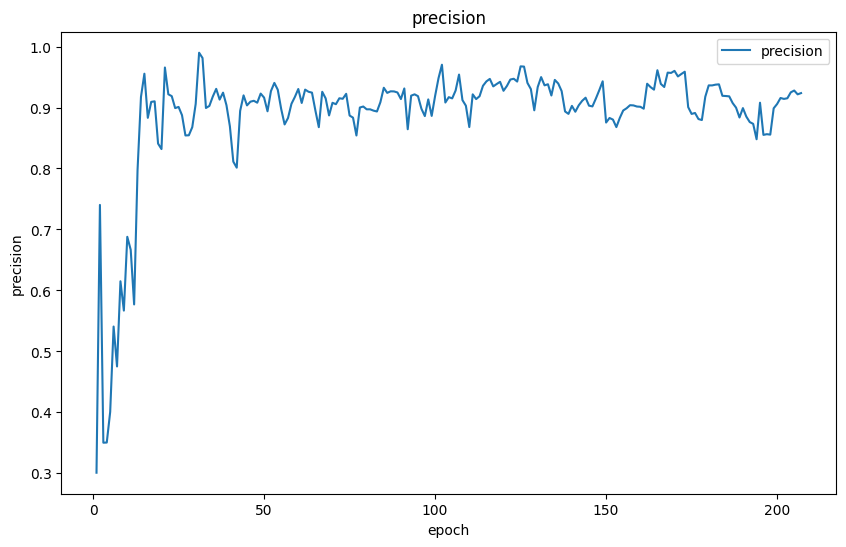

In [18]:
# Plot precision over epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label = 'precision')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('precision')
plt.show()

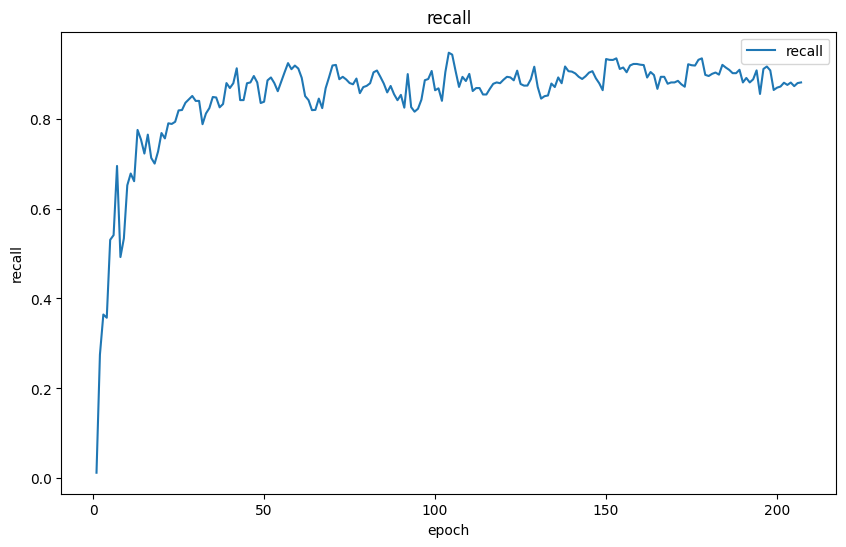

In [19]:
# Plot recall over epochs
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/recall(B)'], label = 'recall')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('recall')
plt.show()

# model predictions

In [3]:
# Load a model
model = YOLO("runs/detect/train/weights/best.pt")  # pretrained YOLOv8n model

# Define the test set directory
test_dir = '/kaggle/working/dataset/images/test'

# Get a list of all test images
test_images = glob.glob(os.path.join(test_dir, '*.jpg'))

# Run predictions on the test set
results = model.predict(test_images, save=True,conf=0.6)


0: 640x640 2 masks, 17.3ms
1: 640x640 2 masks, 17.3ms
2: 640x640 1 mask, 1 no_mask, 17.3ms
3: 640x640 1 mask, 17.3ms
4: 640x640 5 masks, 4 no_masks, 17.3ms
5: 640x640 1 mask, 17.3ms
6: 640x640 4 masks, 17.3ms
7: 640x640 4 masks, 17.3ms
8: 640x640 1 no_mask, 17.3ms
9: 640x640 7 masks, 17.3ms
10: 640x640 3 masks, 17.3ms
11: 640x640 1 no_mask, 17.3ms
12: 640x640 1 mask, 17.3ms
13: 640x640 1 no_mask, 17.3ms
14: 640x640 1 no_mask, 17.3ms
15: 640x640 1 mask, 1 no_mask, 17.3ms
16: 640x640 3 masks, 17.3ms
17: 640x640 1 mask, 17.3ms
18: 640x640 25 masks, 1 no_mask, 17.3ms
19: 640x640 1 mask, 17.3ms
20: 640x640 2 masks, 17.3ms
21: 640x640 2 masks, 1 no_mask, 17.3ms
22: 640x640 2 masks, 17.3ms
23: 640x640 1 mask, 17.3ms
24: 640x640 1 mask, 17.3ms
25: 640x640 1 mask, 17.3ms
26: 640x640 2 masks, 17.3ms
27: 640x640 1 mask, 17.3ms
Speed: 2.9ms preprocess, 17.3ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


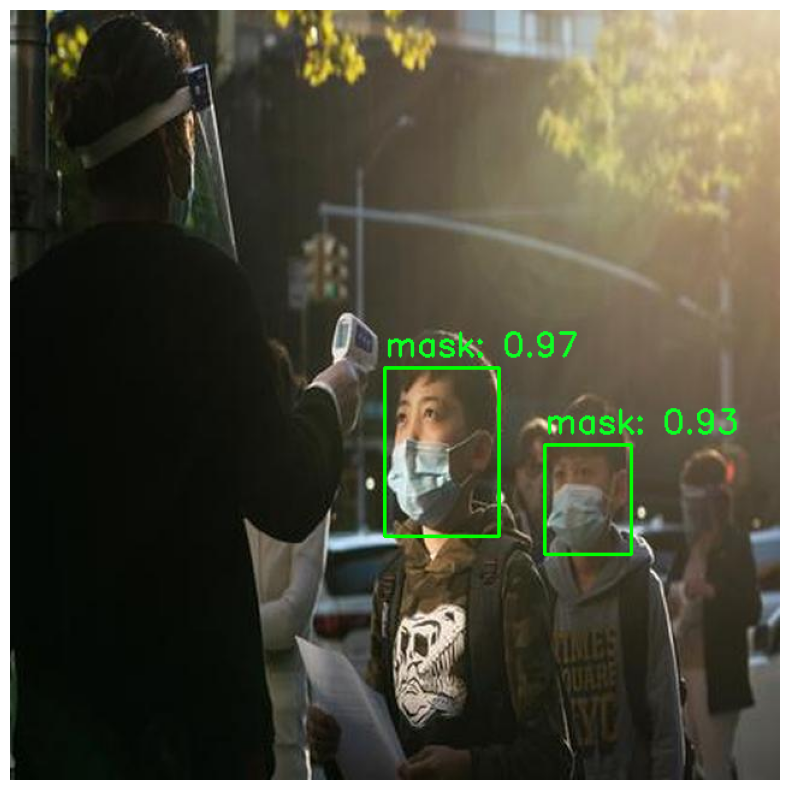

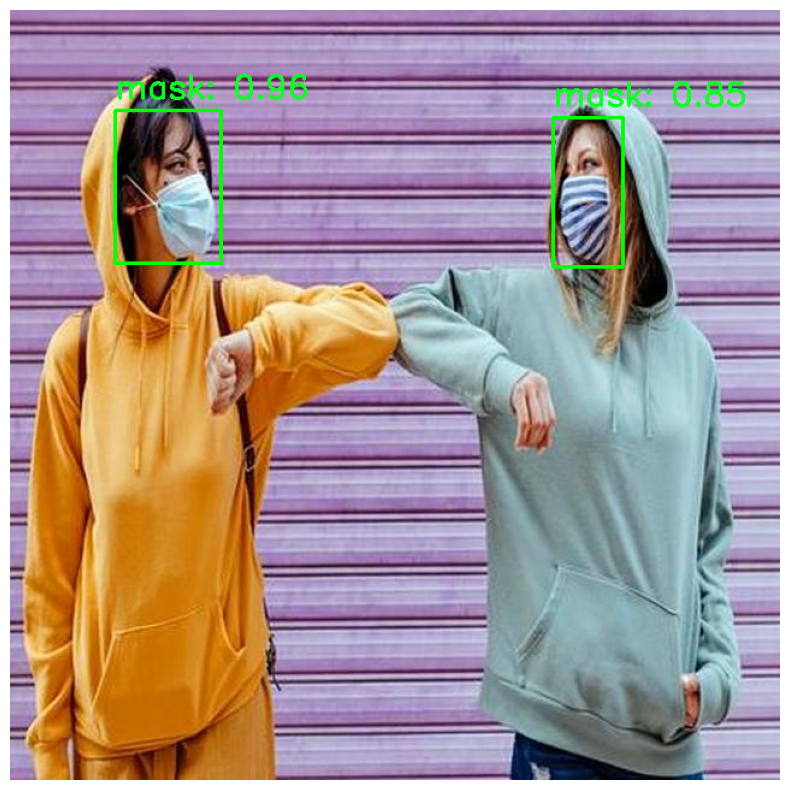

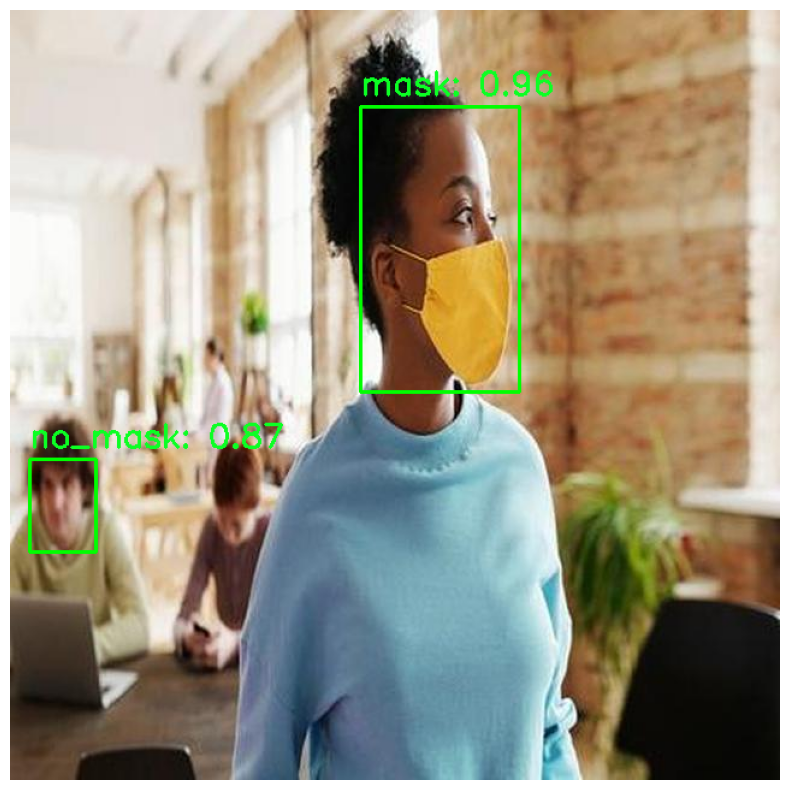

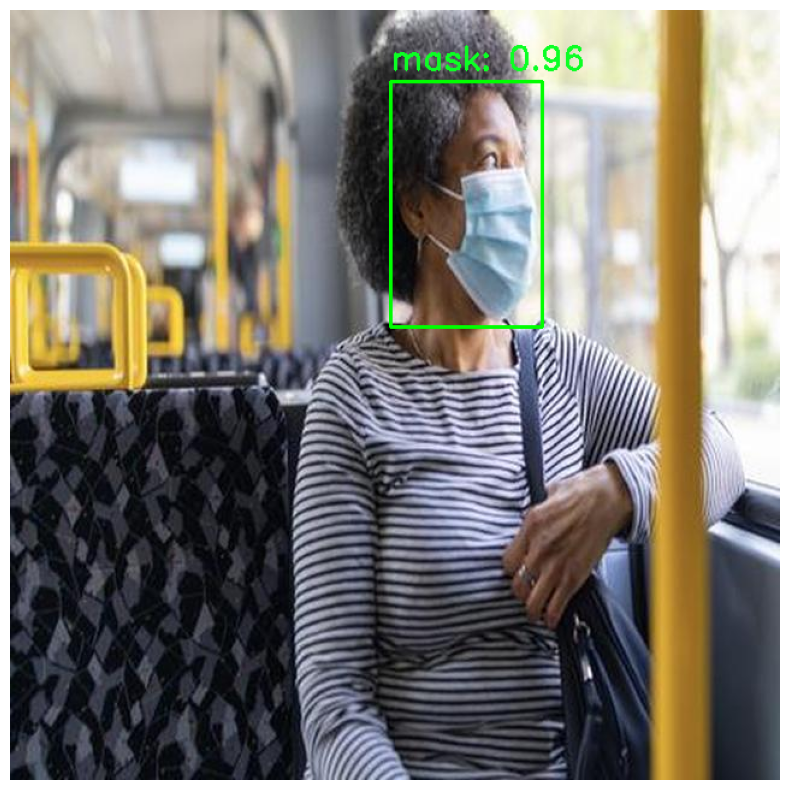

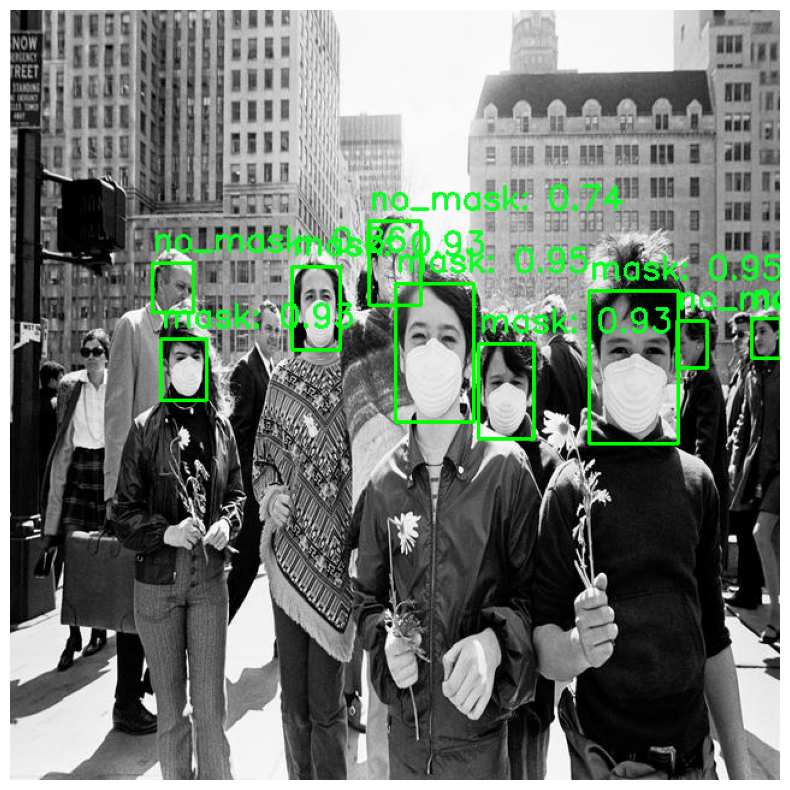

In [5]:
# Function to display an image with predictions
def display_predictions(image_path, results):
    image = cv2.imread(image_path)
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Extract coordinates
        conf = box.conf[0]  # Extract confidence score
        cls = box.cls[0]  # Extract class
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'{model.names[int(cls)]}: {conf:.2f}'
        cv2.putText(image, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display predictions for a few test images
for img_path, result in zip(test_images[:5], results):
    display_predictions(img_path, result)


In [53]:
# Define the output directory for saving prediction images
output_dir = '/kaggle/working/predictions'
os.makedirs(output_dir, exist_ok=True)

# Save the prediction images
for img_path, result in zip(test_images, results):
    image = cv2.imread(img_path)
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Extract coordinates
        conf = box.conf[0]  # Extract confidence score
        cls = box.cls[0]  # Extract class
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f'{model.names[int(cls)]}: {conf:.2f}'
        cv2.putText(image, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_path, image)


In [ ]:
# Compress the training results and prediction images directories into zip files for download
shutil.make_archive('/kaggle/working/runs_n26', 'zip', '/kaggle/working/runs/detect/train5')
shutil.make_archive('/kaggle/working/predictions_n26', 'zip', output_dir)